In [ ]:
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : False})


DATA_SAMPLE_SIZE=7000 # grab 7000 docs

# youtube comments dataset presumably
_dataset = datasets.load_dataset("breadlicker45/youtube-comments-180k")
# grab part of dataset
_dataset1 = _dataset['train'].shuffle(seed=18).select(range(DATA_SAMPLE_SIZE))
_dataset1

## Data

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
''' 
Tokenization
  Lowercase everything
  Remove all symbols other than a-z.
  Split on spaces
  Remove stopwords/empty tokens
  Apply snowball stemmer to remainder
'''

def tokenize(doc):
  stemmer = SnowballStemmer('english')
  _stopwords = stopwords.words('english')
  doc['all_tokens'] = [stemmer.stem(i) for i in re.split( r" +", re.sub(r"[^a-z ]", "", doc['text'].lower()) ) if (i not in _stopwords) and len(i)]
  return doc

_dataset1 = _dataset1.map(tokenize)

Parameter 'function'=<function tokenize at 0x7f73810a8ee0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 7000/7000 [00:04<00:00, 1417.84 examples/s]


In [6]:
_dataset1

Dataset({
    features: ['text', 'all_tokens'],
    num_rows: 7000
})

In [7]:
_dataset1['text'][12]

'You should do a video on how sudden immersion in hot or cold water can give you transient amnesia.'

In [8]:
_dataset1['all_tokens'][12]

['video',
 'sudden',
 'immers',
 'hot',
 'cold',
 'water',
 'give',
 'transient',
 'amnesia']

## Word2vec

In [9]:
from collections import Counter


# shrinking our vocab by selecting only words frequent by at least 10 times
counts = Counter([i for s in _dataset1['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10}

# vocabulary
vocab = list(counts.keys())
print(f"Vocab size: {len(vocab)}")

Vocab size: 1651


In [10]:
# dictionaries

id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

In [11]:
# new attribute with only frequent tokens

def only_freq_tokens(doc, _vocab):
  doc['tokens'] = [t for t in doc['all_tokens'] if t in _vocab]
  return doc

_dataset1 = _dataset1.map(only_freq_tokens, fn_kwargs={"_vocab": vocab})

Map: 100%|██████████| 7000/7000 [00:02<00:00, 2772.00 examples/s]


In [12]:
_dataset1['tokens'][12]

['video', 'sudden', 'hot', 'cold', 'water', 'give']

In [14]:
'''
  contruct data pairs with context word and target word for a given number of context words on each side of the target word
  possible for use for both CBOW & Skip gram models
'''

def prepare_data(doc, token_to_id, clen=1):

  tokens = doc['tokens']
  windows = []

  for i, wd in enumerate(tokens):
    target = token_to_id[wd]
    contexts = [i+j for j in range(-clen, clen+1, 1) if (i+j>=0) & (i+j<len(tokens)) & (j!=0)]
    windows += ([(token_to_id[tokens[wi]], target) for wi in contexts])
    
  doc['data'] = windows
  return doc

_dataset1 = _dataset1.map(prepare_data, fn_kwargs={"token_to_id":tok2id})

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map: 100%|██████████| 7000/7000 [00:01<00:00, 5864.31 examples/s]


In [15]:
_dataset1['data'][12]

[[102, 101],
 [101, 102],
 [103, 102],
 [102, 103],
 [104, 103],
 [103, 104],
 [105, 104],
 [104, 105],
 [106, 105],
 [105, 106]]

In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


# custom dataset class for convenience
class Word2VecDataset(Dataset):
  
  # Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader
  def __init__(self, dataset, vocab_size):
    self.dataset = dataset
    self.vocab_size = vocab_size
    self.contexts = torch.tensor([ctx for ctxs in dataset['data'] for ctx, _ in ctxs])
    self.targets = torch.tensor([tgt for tgts in dataset['data'] for _, tgt in tgts])

  def __len__(self):
    return len(self.contexts)
  
  def __getitem__(self, idx):
    return self.contexts[idx], self.targets[idx]

## Model

In [17]:
# dataloader

BATCH_SIZE = 2**5

training_dataset = Word2VecDataset(dataset=_dataset1, vocab_size=len(vocab))
training_dataloader = DataLoader(training_dataset, shuffle=True, batch_size=BATCH_SIZE)

print(len(training_dataset.contexts))
for c, t in training_dataloader:
  print(f"context: {c} {c.shape} {c.dtype}")
  print(f"target: {t} {t.shape} {t.dtype}")
  break

141274
context: tensor([ 383,  718, 1289, 1401,  423,  402,  234, 1026,  873,  319,  483,  594,
         423,  339,  512,  328,  244, 1084,  507,  145,  585,  120, 1283,  369,
         658,  850,  106,  180,  602,  112,  980, 1041]) torch.Size([32]) torch.int64
target: tensor([1011,  149, 1285, 1009,  188,  395,  810,  233,  825, 1306,  595,  434,
         254,  132,  265,   45, 1158,   34,  433,    4,   53,  459,  170, 1403,
         886, 1318,  960,  174,   97,  596,  297,   34]) torch.Size([32]) torch.int64


In [18]:
''' 
  Neural network with input, hidden, & output layer
  works as CBOW & Skip-gram depending on training data
'''

class Word2Vec(torch.nn.Module):
  
  def __init__(self, input_layer_dim, hidden_layer_dim):
    super().__init__()
    # embedding layer allows us to omit manual conversion of our token ids into one-hot encoded vectors
    self.layer1 = nn.Embedding(input_layer_dim, hidden_layer_dim)
    self.layer2 = nn.Linear(hidden_layer_dim, input_layer_dim)
    
  def forward(self, inputs):
    # Encode input to lower-dimensional representation
    layer1_outs = self.layer1(inputs)
    # Expand hidden layer to predictions
    layer2_outs = self.layer2(layer1_outs)
    return layer2_outs

### Training

In [19]:
# training function

def train(model, loss_fn, optimizer, dataloader, epochs):

  losses = []
  for e in range(epochs):
    model.train()
    for context, target in dataloader:
      preds = model(context)
      loss = loss_fn(preds, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print(f"Epoch #{e+1}: loss={loss}")
    losses.append(loss.item())
  
  return losses

In [20]:
len(training_dataloader)

4415

In [21]:
# Instantiate the model
HIDDEN_LAYER_SIZE = 75
model = Word2Vec(input_layer_dim=len(vocab), hidden_layer_dim=HIDDEN_LAYER_SIZE)

# Define training parameters
LR = 1e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR)

losses = train(model, loss_fn, optimizer, training_dataloader, EPOCHS)

Epoch #1: loss=7.442708492279053
Epoch #2: loss=7.317708492279053
Epoch #3: loss=7.127079486846924
Epoch #4: loss=7.008585453033447
Epoch #5: loss=6.968353271484375
Epoch #6: loss=6.793277263641357
Epoch #7: loss=6.954165935516357
Epoch #8: loss=6.929793357849121
Epoch #9: loss=6.623084545135498
Epoch #10: loss=6.578116416931152


### Semantic progression

In [22]:
sorted(counts.items(), key=lambda x: -x[1])[:10]

[('like', 1027),
 ('one', 663),
 ('would', 658),
 ('get', 653),
 ('peopl', 601),
 ('use', 565),
 ('game', 561),
 ('video', 560),
 ('dont', 539),
 ('make', 536)]

In [23]:
# check for the closest words in terms of the vectors

from scipy.spatial import distance


def get_distance_matrix(wordvecs, metric):
  dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
  return dist_matrix

# obtain most similar words by word embeddings
def get_k_similar_words(word, dist_matrix, id_to_token, token_to_id, k=7):
  idx = token_to_id[word]
  dists = dist_matrix[idx]
  ids = np.argpartition(dists, k)[:k+1] # avoid sorting all the distances
  ids = ids[np.argsort(dists[ids])][1:] # excluding match with itself
  res = [(i, id_to_token[i], dists[i]) for i in ids]
  return res

In [24]:
sample_tokens = ['good', 'time', 'love', 'watch', 'podcast']

wordvecs = model.layer2.weight.cpu().detach().numpy()
dmat = get_distance_matrix(wordvecs, 'cosine')
for word in sample_tokens:
  print(word, [(t[1], t[2].round(3)) for t in get_k_similar_words(word, dmat, id2tok, tok2id)])

good [('make', 0.42), ('great', 0.458), ('like', 0.47), ('know', 0.486), ('see', 0.495), ('thing', 0.496), ('also', 0.496)]
time [('see', 0.535), ('say', 0.583), ('last', 0.611), ('long', 0.615), ('thing', 0.618), ('know', 0.623), ('use', 0.64)]
love [('way', 0.559), ('thank', 0.562), ('good', 0.57), ('great', 0.576), ('lex', 0.578), ('better', 0.58), ('need', 0.584)]
watch [('done', 0.526), ('lex', 0.554), ('ive', 0.579), ('say', 0.601), ('next', 0.61), ('see', 0.626), ('find', 0.632)]
podcast [('listen', 0.543), ('interview', 0.607), ('heard', 0.645), ('havent', 0.662), ('question', 0.666), ('final', 0.673), ('refer', 0.673)]


In [25]:
# train for more epochs

losses = train(model, loss_fn, optimizer, training_dataloader, 30)

Epoch #1: loss=6.764237403869629
Epoch #2: loss=6.225449562072754
Epoch #3: loss=6.461740493774414
Epoch #4: loss=6.739405155181885
Epoch #5: loss=6.003942012786865
Epoch #6: loss=6.275568008422852
Epoch #7: loss=6.771100997924805
Epoch #8: loss=6.85062313079834
Epoch #9: loss=6.500457763671875
Epoch #10: loss=6.56160831451416
Epoch #11: loss=6.37736177444458
Epoch #12: loss=6.278547286987305
Epoch #13: loss=6.324886798858643
Epoch #14: loss=6.244394779205322
Epoch #15: loss=6.7616167068481445
Epoch #16: loss=6.421751976013184
Epoch #17: loss=6.308559894561768
Epoch #18: loss=6.192746162414551
Epoch #19: loss=6.256975173950195
Epoch #20: loss=6.32423210144043
Epoch #21: loss=6.5580315589904785
Epoch #22: loss=6.584868431091309
Epoch #23: loss=6.076176643371582
Epoch #24: loss=6.3468780517578125
Epoch #25: loss=6.352540969848633
Epoch #26: loss=5.95976448059082
Epoch #27: loss=6.340043067932129
Epoch #28: loss=5.975517272949219
Epoch #29: loss=6.154322147369385
Epoch #30: loss=6.3666052

In [26]:
# train more to see better results

weiter_wordvecs = model.layer2.weight.cpu().detach().numpy()
weiter_dmat = get_distance_matrix(weiter_wordvecs, 'cosine')
for word in sample_tokens:
  print(word, [(t[1], t[2].round(3)) for t in get_k_similar_words(word, weiter_dmat, id2tok, tok2id)])

good [('make', 0.398), ('great', 0.423), ('like', 0.433), ('realli', 0.473), ('know', 0.496), ('see', 0.51), ('think', 0.522)]
time [('see', 0.536), ('thing', 0.541), ('one', 0.582), ('minut', 0.61), ('peopl', 0.62), ('long', 0.622), ('show', 0.629)]
love [('thank', 0.507), ('lex', 0.525), ('good', 0.554), ('enjoy', 0.587), ('great', 0.587), ('way', 0.622), ('tom', 0.624)]
watch [('listen', 0.59), ('see', 0.602), ('video', 0.615), ('ever', 0.621), ('riley', 0.627), ('good', 0.648), ('ive', 0.651)]
podcast [('listen', 0.53), ('lex', 0.562), ('interview', 0.581), ('interest', 0.607), ('wow', 0.609), ('guest', 0.609), ('episod', 0.611)]


## Experiment

### Progression with dimension of hidden layer

In [31]:
data_sample_size = 2000
_dataset2 = _dataset['train'].shuffle(seed=33).select(range(data_sample_size))
_dataset2

Dataset({
    features: ['text'],
    num_rows: 2000
})

In [32]:
_dataset2 = _dataset2.map(tokenize)

counts2 = Counter([i for s in _dataset2['all_tokens'] for i in s])
counts2 = {k:v for k, v in counts2.items() if v>10}
vocab2 = list(counts2.keys())
print(len(vocab2))

id2tok2 = dict(enumerate(vocab2))
tok2id2 = {token: id for id, token in id2tok2.items()}

_dataset2 = _dataset2.map(only_freq_tokens, fn_kwargs={"_vocab": vocab2})
_dataset2 = _dataset2.map(prepare_data, fn_kwargs={"token_to_id": tok2id2})

666


In [33]:
batch_size2 = 2**5
training_dataset2 = Word2VecDataset(dataset=_dataset2, vocab_size=len(vocab2))
training_dataloader2 = DataLoader(training_dataset2, shuffle=True, batch_size=batch_size2)

print(len(training_dataset2.contexts))
for c, t in training_dataloader2:
  print(f"context: {c} {c.shape} {c.dtype}")
  print(f"target: {t} {t.shape} {t.dtype}")
  break

38228
context: tensor([231, 272, 448, 108, 201, 370, 101,  87, 152, 119, 392,  49, 283, 569,
        246, 234, 400,  18, 273,  18, 272,  35, 218, 233,  39, 384, 623,  40,
         15, 272, 545,  29]) torch.Size([32]) torch.int64
target: tensor([527, 293, 206, 145,   3, 121, 102, 571, 125, 423, 608,   6, 258, 272,
        106, 281, 286, 104, 611, 427, 569, 240, 410,  36,  28, 486,  18,  29,
        131, 569, 544,  76]) torch.Size([32]) torch.int64


In [34]:
hidden_layer_sizes = range(10, 201, 19)
epochs = 20
learning_rate = 5e-4
all_losses2 = []

for hdim in hidden_layer_sizes:
  model_tmp = Word2Vec(input_layer_dim=len(vocab2), hidden_layer_dim=hdim)
  print(f"Hidden layer dims: {hdim}")
  losses = train(
    model=model_tmp,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.AdamW(params=model_tmp.parameters(), lr=learning_rate),
    dataloader=training_dataloader2,
    epochs=epochs
  )
  print("-------------------------------")
  all_losses2.append(losses[-1])

Hidden layer dims: 10
Epoch #1: loss=6.472251892089844
Epoch #2: loss=5.967734336853027
Epoch #3: loss=5.697275161743164
Epoch #4: loss=6.114223003387451
Epoch #5: loss=5.493648529052734
Epoch #6: loss=5.946589469909668
Epoch #7: loss=5.958173751831055
Epoch #8: loss=6.04478120803833
Epoch #9: loss=5.90346622467041
Epoch #10: loss=5.984967231750488
Epoch #11: loss=5.174130439758301
Epoch #12: loss=5.547682762145996
Epoch #13: loss=5.265565395355225
Epoch #14: loss=5.6195597648620605
Epoch #15: loss=5.413209438323975
Epoch #16: loss=5.55916690826416
Epoch #17: loss=6.105984687805176
Epoch #18: loss=6.12661075592041
Epoch #19: loss=5.022160053253174
Epoch #20: loss=5.495583534240723
-------------------------------
Hidden layer dims: 29
Epoch #1: loss=6.653031826019287
Epoch #2: loss=5.5891242027282715
Epoch #3: loss=5.4906110763549805
Epoch #4: loss=6.024300575256348
Epoch #5: loss=5.373116493225098
Epoch #6: loss=5.7780351638793945
Epoch #7: loss=5.671077728271484
Epoch #8: loss=5.41953

In [35]:
all_losses2

[5.495583534240723,
 5.8611931800842285,
 4.871235370635986,
 5.655630588531494,
 4.750367164611816,
 4.185981273651123,
 4.648394584655762,
 4.696467876434326,
 4.519140720367432,
 4.346634864807129,
 3.988445281982422]

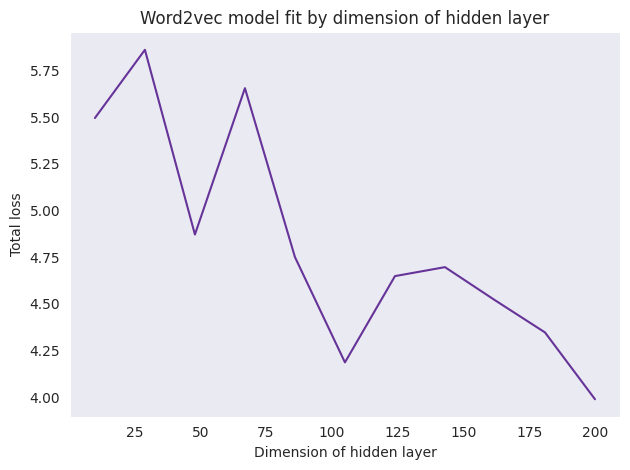

In [36]:
df2 = pd.DataFrame.from_dict({"dim": hidden_layer_sizes, "loss": all_losses2})
sns.lineplot(data=df2, x="dim", y="loss", color="rebeccapurple")
plt.xlabel(xlabel='Dimension of hidden layer')
plt.ylabel(ylabel='Total loss')
plt.title("Word2vec model fit by dimension of hidden layer")
plt.tight_layout()
plt.show()

### Progression with number of words used in training/vocabulary size

In [37]:
data_sample_sizes = range(1000, 6001, 1000)
batch_size3 = 2**5
hidden_layer_size3 = 100
epochs = 10
learning_rate = 1e-4

training_words = []
all_losses3 = []

for ds in data_sample_sizes:
  _dataset3 = _dataset['train'].shuffle(seed=33).select(range(ds))
  _dataset3 = _dataset3.map(tokenize)

  counts3 = Counter([i for s in _dataset3['all_tokens'] for i in s])
  counts3 = {k:v for k, v in counts3.items() if v>10}
  vocab3 = list(counts3.keys())

  id2tok3 = dict(enumerate(vocab3))
  tok2id3 = {token: id for id, token in id2tok3.items()}

  _dataset3 = _dataset3.map(only_freq_tokens, fn_kwargs={"_vocab": vocab3})
  _dataset3 = _dataset3.map(prepare_data, fn_kwargs={"token_to_id": tok2id3})

  training_dataset3 = Word2VecDataset(dataset=_dataset3, vocab_size=len(vocab3))
  training_dataloader3 = DataLoader(training_dataset3, shuffle=True, batch_size=batch_size3)

  print(f"# of training samples: {len(training_dataset3.contexts)}")

  model_tmp = Word2Vec(input_layer_dim=len(vocab3), hidden_layer_dim=hidden_layer_size3)
  print(f"# of training words: {len(vocab3)}")
  losses = train(
    model=model_tmp,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.AdamW(params=model_tmp.parameters(), lr=learning_rate),
    dataloader=training_dataloader3,
    epochs=epochs
  )
  print("-------------------------------")
  training_words.append(len(vocab3))
  all_losses3.append(losses[-1])


Map: 100%|██████████| 1000/1000 [00:00<00:00, 12082.14 examples/s]


# of training samples: 11470
# of training words: 268
Epoch #1: loss=5.488856315612793
Epoch #2: loss=5.325942516326904
Epoch #3: loss=5.867912769317627
Epoch #4: loss=5.262505054473877
Epoch #5: loss=5.59533166885376
Epoch #6: loss=5.432192802429199
Epoch #7: loss=5.330134868621826
Epoch #8: loss=5.653270244598389
Epoch #9: loss=5.373314380645752
Epoch #10: loss=5.508280277252197
-------------------------------
# of training samples: 38228
# of training words: 666
Epoch #1: loss=6.222690105438232
Epoch #2: loss=6.442712306976318
Epoch #3: loss=6.186081886291504


Epoch #4: loss=6.4125847816467285
Epoch #5: loss=5.469555854797363
Epoch #6: loss=6.428639888763428
Epoch #7: loss=5.250039577484131
Epoch #8: loss=5.945876598358154
Epoch #9: loss=6.13749885559082
Epoch #10: loss=5.568637371063232
-------------------------------


Map: 100%|██████████| 3000/3000 [00:00<00:00, 10884.03 examples/s]


# of training samples: 59336
# of training words: 914
Epoch #1: loss=6.791168689727783
Epoch #2: loss=6.132397651672363
Epoch #3: loss=6.451742172241211
Epoch #4: loss=6.350168704986572
Epoch #5: loss=6.736303806304932
Epoch #6: loss=5.94467306137085
Epoch #7: loss=6.0528106689453125
Epoch #8: loss=6.142726898193359
Epoch #9: loss=6.287188529968262
Epoch #10: loss=4.282767295837402
-------------------------------


Map: 100%|██████████| 4000/4000 [00:00<00:00, 11260.17 examples/s]


# of training samples: 80922
# of training words: 1150
Epoch #1: loss=7.1503987312316895
Epoch #2: loss=6.849947929382324
Epoch #3: loss=6.618770122528076
Epoch #4: loss=6.044053077697754
Epoch #5: loss=6.607739448547363
Epoch #6: loss=6.327540397644043
Epoch #7: loss=6.132623672485352
Epoch #8: loss=6.52421236038208
Epoch #9: loss=6.3139238357543945
Epoch #10: loss=6.006372451782227
-------------------------------


Map: 100%|██████████| 5000/5000 [00:00<00:00, 8501.54 examples/s] 


# of training samples: 103920
# of training words: 1365
Epoch #1: loss=7.473354339599609
Epoch #2: loss=6.2611494064331055
Epoch #3: loss=7.208996295928955
Epoch #4: loss=5.910832405090332
Epoch #5: loss=6.719745635986328
Epoch #6: loss=6.765536308288574
Epoch #7: loss=6.643338203430176
Epoch #8: loss=6.597057342529297
Epoch #9: loss=6.302463054656982
Epoch #10: loss=6.37977409362793
-------------------------------


Map: 100%|██████████| 6000/6000 [00:00<00:00, 7273.58 examples/s]


# of training samples: 127020
# of training words: 1560
Epoch #1: loss=7.310261249542236
Epoch #2: loss=6.293386459350586
Epoch #3: loss=7.100456237792969
Epoch #4: loss=6.130274295806885
Epoch #5: loss=6.266075134277344
Epoch #6: loss=6.486093044281006
Epoch #7: loss=6.525592803955078
Epoch #8: loss=6.599704742431641
Epoch #9: loss=5.566153049468994
Epoch #10: loss=5.87553596496582
-------------------------------


In [38]:
training_words

[268, 666, 914, 1150, 1365, 1560]

In [39]:
all_losses3

[5.508280277252197,
 5.568637371063232,
 4.282767295837402,
 6.006372451782227,
 6.37977409362793,
 5.87553596496582]

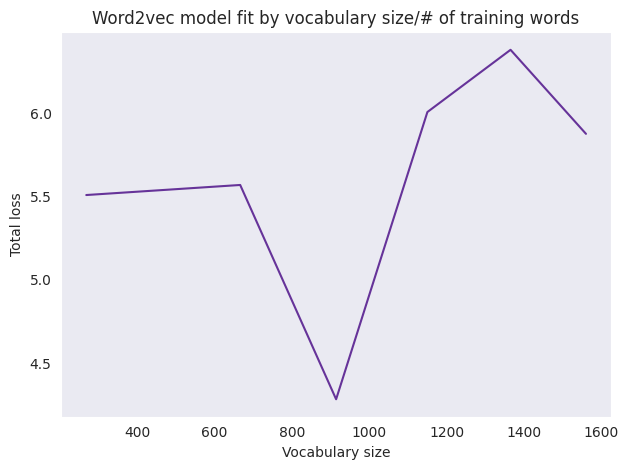

In [40]:
df3 = pd.DataFrame.from_dict({"train_words": training_words, "loss": all_losses3})
sns.lineplot(data=df3, x="train_words", y="loss", color="rebeccapurple")
plt.xlabel(xlabel='Vocabulary size')
plt.ylabel(ylabel='Total loss')
plt.title("Word2vec model fit by vocabulary size/# of training words")
plt.tight_layout()
plt.show()